In [31]:
'''
Finger flexion prediction using regular machine learning models
@author: Deng Chijun
@date: 2024.11.24

'''
import logging
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [32]:
'''
load data
'''
root_dir = 'E:/Code/Class_Project/BCI_Prj_New/dataset'
os.chdir(root_dir)

## subid
subid = 1

### load data
data_process_dir = f'{root_dir}/BCI_Competion4_dataset4_data_fingerflexions/s_preprocessing/sub{subid}'

# train
X_train = np.load(f'{data_process_dir}/train/ecog_data.npy')
y_train_all = np.load(f'{data_process_dir}/train/fingerflex_data.npy')

# test
X_test = np.load(f'{data_process_dir}/val/ecog_data.npy')
y_test_all = np.load(f'{data_process_dir}/val/fingerflex_data.npy')

# # corr feature
# X_train_corr = CorrMatrix(X_train)
# X_test_corr = CorrMatrix(X_test)

## reshape data
X_train = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2]).transpose(1, 0)
X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2]).transpose(1, 0)

# Select specific finger
y_train = y_train_all.transpose(1, 0)
y_test = y_test_all.transpose(1, 0)


In [33]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [34]:
from sklearn.neighbors import KNeighborsRegressor

'''
model, train and evaluation 
'''
# Initialize the XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Learning rate
    max_depth=3,           # Maximum depth of a tree
    subsample=0.8,         # Fraction of samples used for fitting individual trees
    colsample_bytree=0.8,  # Fraction of features used for fitting individual trees
    random_state=42
)

# Initialize the LGBMRegressor
lgbm = LGBMRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.05,     # Reduced learning rate
    max_depth=-1,           # No depth limit
    min_data_in_leaf=10,    # Minimum samples per leaf
    subsample=0.8,          # Use 80% of data for training each tree
    colsample_bytree=0.8,   # Use 80% of features for training each tree
    random_state=42
)

# 其他可以尝试的模型
rf = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of each tree
    min_samples_split=2,    # Minimum samples to split an internal node
    min_samples_leaf=1,     # Minimum samples required in a leaf node
    max_features=100,    # Number of features to consider when looking for the best split
    random_state=42         # Random seed for reproducibility
)

gbr = GradientBoostingRegressor(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Learning rate
    max_depth=3,            # Maximum depth of the individual regression estimators
    min_samples_split=2,    # Minimum number of samples required to split an internal node
    min_samples_leaf=1,     # Minimum number of samples required in a leaf node
    subsample=0.8,          # Fraction of samples used for fitting the individual estimators
    random_state=42         # Random seed for reproducibility
)

et = ExtraTreesRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of the trees
    min_samples_split=2,    # Minimum samples to split an internal node
    min_samples_leaf=1,     # Minimum samples required in a leaf node
    max_features='auto',    # Number of features to consider when looking for the best split
    random_state=42         # Random seed for reproducibility
)

svr = SVR(
    kernel='rbf',           # Kernel type (radial basis function)
    C=1.0,                  # Regularization parameter
    epsilon=0.1             # Epsilon in the epsilon-SVR model
)

knn = KNeighborsRegressor(
    n_neighbors=5,          # Number of neighbors to use
    weights='uniform',      # Weight function ('uniform' or 'distance')
    algorithm='auto',       # Algorithm to compute nearest neighbors
    leaf_size=30,           # Leaf size for tree-based algorithms
    metric='minkowski',     # Distance metric
    p=2                     # Power parameter for Minkowski metric
)

ridge = Ridge(              #岭回归
    alpha=1.0,              # Regularization strength (L2 penalty)
    solver='auto',          # Solver to use ('auto', 'svd', 'cholesky', etc.)
    random_state=42         # Random seed for reproducibility
)

lasso = Lasso(              #Lasso回归
    alpha=0.1,              # Regularization strength (L1 penalty)
    max_iter=1000,          # Maximum number of iterations
    random_state=42         # Random seed for reproducibility
)

mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Number of neurons in each hidden layer
    activation='relu',            # Activation function ('tanh', 'relu', etc.)
    solver='adam',                # Solver for weight optimization ('lbfgs', 'sgd', 'adam')
    max_iter=500,                 # Maximum number of iterations
    learning_rate='adaptive',     # Learning rate schedule ('constant', 'invscaling', 'adaptive')
    random_state=42               # Random seed for reproducibility
)

stacking = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),  # Base model 1: Random Forest
        ('ridge', Ridge(alpha=1.0))                                      # Base model 2: Ridge Regression
    ],
    final_estimator=LinearRegression(),     # Final meta-model
    cv=5                                    # Cross-validation splits
)

voting = VotingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=1.0)),        # Model 1: Ridge Regression
        ('gbr', GradientBoostingRegressor(n_estimators=50))  # Model 2: Gradient Boosting
    ],
    weights=[1, 2]                          # Weight for each model in the voting
)

linear = LinearRegression()



In [35]:
# knn rho=0.4
# mlp rho=-0.1
# rf  rho_mean = 0.589, MSE_mean = 0.022  #感觉还可以
#gbr rho_mean = 0.590, MSE_mean = 0.020


In [36]:
# Multi-output regression with GridSearchCV
model = MultiOutputRegressor(gbr)
model_name = 'gbr'

# fit
model.fit(X_train, y_train)

# Evaluate on testing set
y_pred = model.predict(X_test)

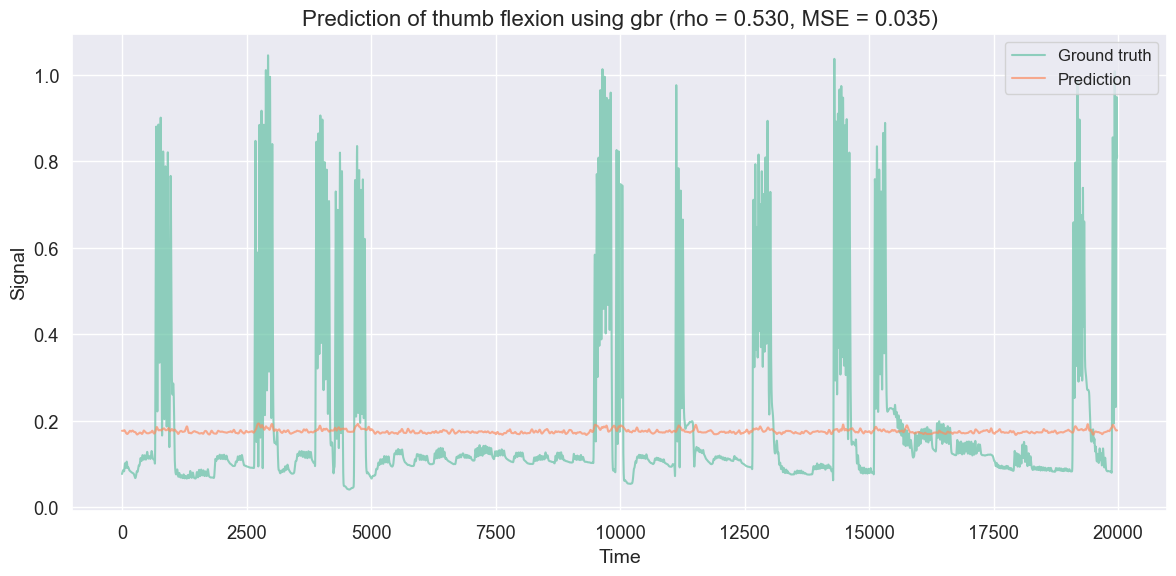

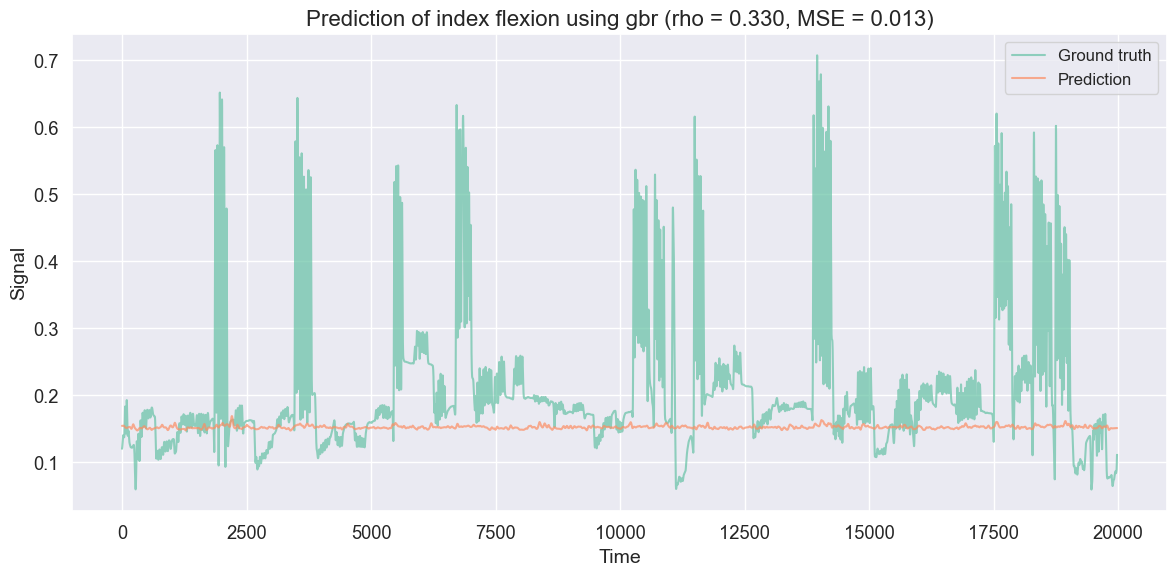

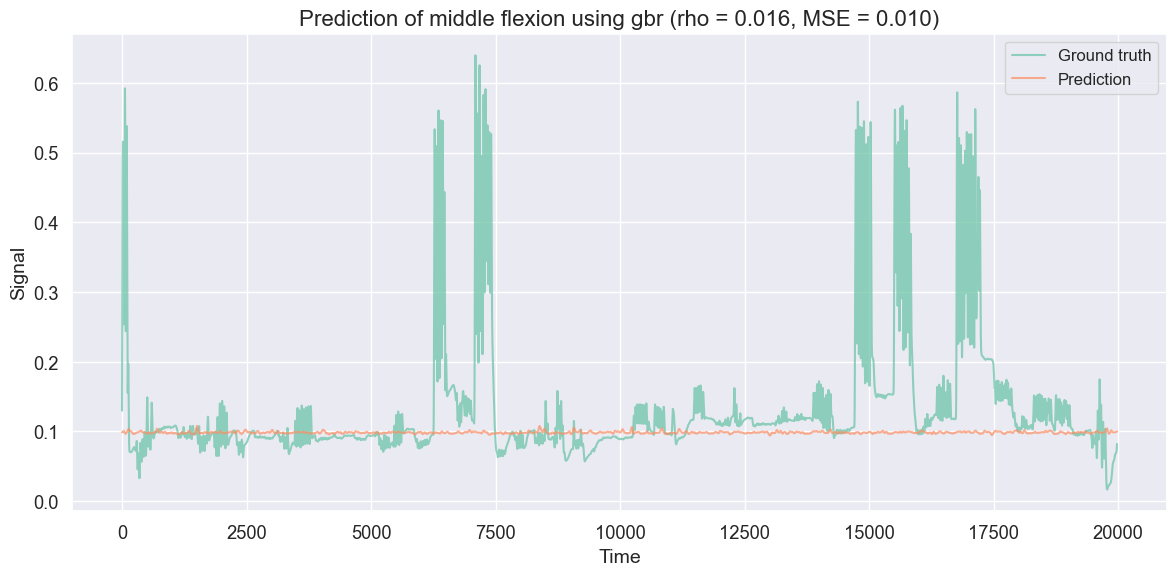

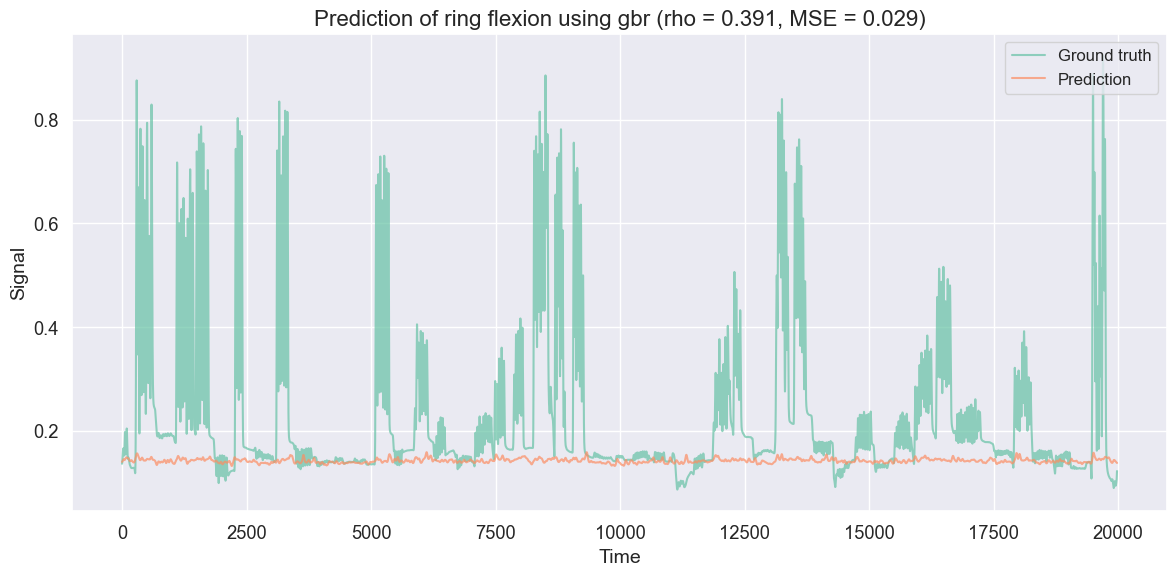

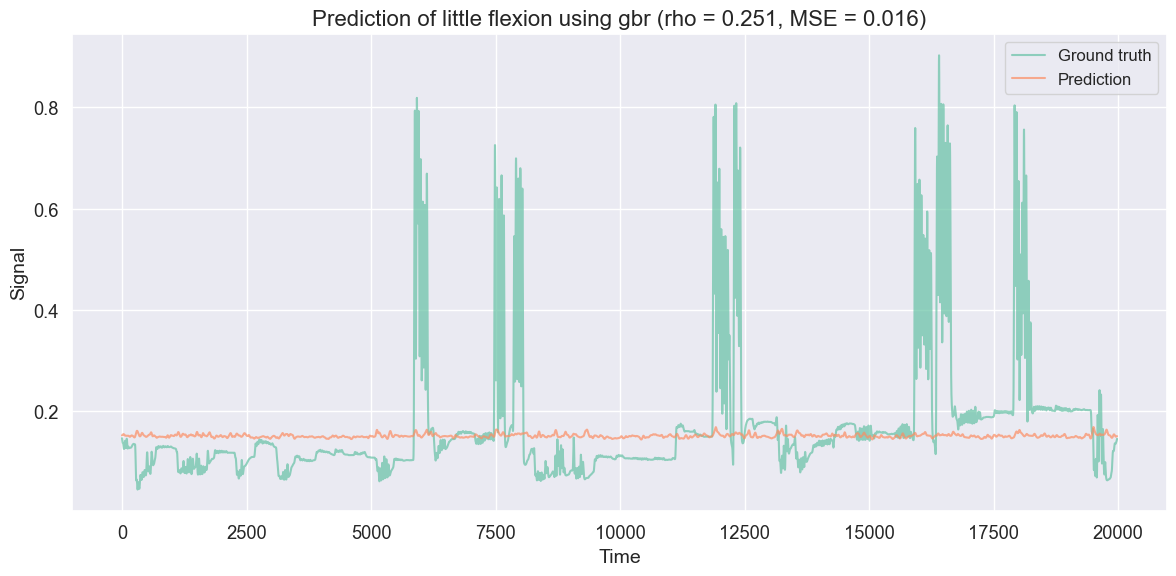

Prediction of thumb flexion using gbr (rho = 0.530, MSE = 0.035)
Prediction of index flexion using gbr (rho = 0.330, MSE = 0.013)
Prediction of middle flexion using gbr (rho = 0.016, MSE = 0.010)
Prediction of ring flexion using gbr (rho = 0.391, MSE = 0.029)
Prediction of little flexion using gbr (rho = 0.251, MSE = 0.016)
Prediction of All flexion using gbr (rho_mean = 0.304, MSE_mean = 0.020)


In [37]:
'''
Calculate Pearson correlation, MSE for each finger
'''
fingers = ['thumb', 'index', 'middle', 'ring', 'little']
sigma = 15 

rho_all = []
mse_all = []

for finger_id, finger_name in enumerate(fingers):
    
    y_test_single = y_test[:, finger_id].ravel()
    y_pred_single = y_pred[:, finger_id].ravel()
    
    # filter outputs
    y_pred_filter = gaussian_filter1d(y_pred_single, sigma=sigma)
    # metrics
    rho, _ = pearsonr(y_test_single, y_pred_filter)
    mse = mean_squared_error(y_test_single, y_pred_filter)

    rho_all.append(rho)
    mse_all.append(mse)

    '''
    Visualize
    '''
    sns.set_theme(style='darkgrid', font_scale=1.2)
    # Define a color palette
    colors = sns.color_palette("Set2", 2) 
    # Plot original y vs. predicted y
    plt.figure(figsize=(12, 6))
    
    # Plot original y
    plt.plot(y_test_single, label="Ground truth", alpha=0.7, color=colors[0])
    
    # Plot predicted y
    plt.plot(y_pred_filter.ravel(), label="Prediction", alpha=0.7, color=colors[1])
    
    # Adding labels and legend
    plt.title(f"Prediction of {finger_name} flexion using {model_name} (rho = {rho:.3f}, MSE = {mse:.3f})", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Signal", fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for idx, finger_name in enumerate(fingers):
    print(f"Prediction of {finger_name} flexion using {model_name} (rho = {rho_all[idx]:.3f}, MSE = {mse_all[idx]:.3f})")

print(f"Prediction of All flexion using {model_name} (rho_mean = {np.mean(rho_all):.3f}, MSE_mean = {np.mean(mse_all):.3f})")